# Regularization

For neural networks, regularization helps prevent overfitting by constraining the network's weights or activations so it doesn't memorize the training data. It encourages the network to learn patterns that generalize to new data.

Common ways to add regularization in neural networks include:

- L1/L2 weight penalties – add a term to the loss that penalizes large weights (L2 is called weight decay).

- Dropout: randomly sets some neurons to zero during training, forcing the network to be redundant and robust.

- Early stopping: stop training when validation loss stops improving.

- Data augmentation: artificially expand the dataset to make the network see more variations. eg. adding noise

- Limiting model size

This notebook will go over a few of these

#### Limiting model size

Take the example from 2_mlp.ipynb but this time with a more complex model:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim

In [11]:
X, y = make_moons(n_samples=200, noise=0.2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


In [33]:
model = Net1()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

Epoch 200/1000, Loss: 0.0171
Epoch 400/1000, Loss: 0.0058
Epoch 600/1000, Loss: 0.0019
Epoch 800/1000, Loss: 0.0007
Epoch 1000/1000, Loss: 0.0003


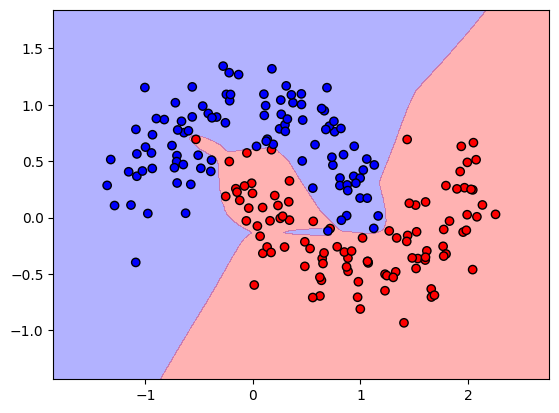

In [34]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    y_min, y_max = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_t = torch.tensor(grid, dtype=torch.float32)
    model.eval()
    with torch.no_grad():
        probs = model(grid_t).numpy()
    probs = probs.reshape(xx.shape)
    
    plt.contourf(xx, yy, probs, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])
    plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr, edgecolor='k')
    plt.show()

plot_decision_boundary(model, X, y)

This is clearly overfitted now. Limiting model size is a simple way of adding regularization. (Compare to 2_mlp.ipynb)

### L2-regularization

L2 adds a penalty to the loss function proportional to the square of weights. (L1 is proportional to the absolute value of the weights)

Epoch 200/1000, Loss: 0.1398
Epoch 400/1000, Loss: 0.1398
Epoch 600/1000, Loss: 0.1396
Epoch 800/1000, Loss: 0.1395
Epoch 1000/1000, Loss: 0.1395


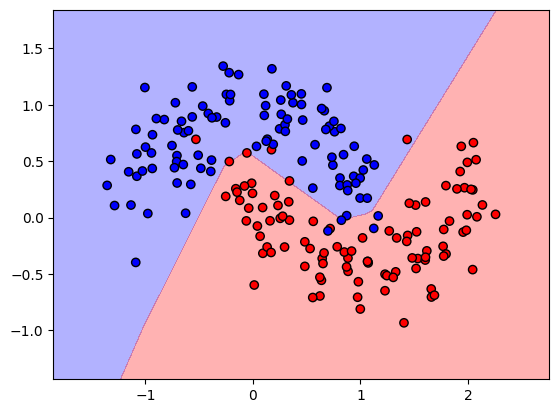

In [29]:
model = Net1()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)  # L2 regularization with weight_decay

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

plot_decision_boundary(model, X, y)

### Dropout

Blocking random neurons from activating each train iteration and therefore forcing the model to learn the same patterns in multiple ways.

In [30]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)   # Dropout after first hidden layer
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)   # Dropout after second hidden layer
        self.fc3 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


Epoch 200/1000, Loss: 0.0599
Epoch 400/1000, Loss: 0.0391
Epoch 600/1000, Loss: 0.0616
Epoch 800/1000, Loss: 0.0256
Epoch 1000/1000, Loss: 0.0489


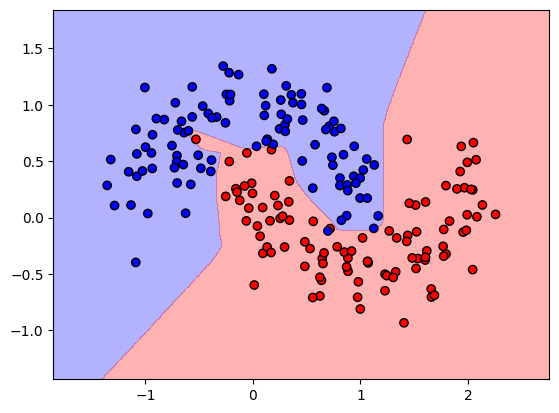

In [32]:
model2 = Net2()
criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.01)

# Training loop
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model2(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 200 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
        
plot_decision_boundary(model2, X, y)